In [226]:
import os
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelBinarizer

!pip install lifelines
from lifelines import KaplanMeierFitter
from lifelines.statistics import logrank_test

import warnings
warnings.filterwarnings("ignore")

%matplotlib inline

plt.rcParams['figure.figsize'] = [9, 6]
plt.rcParams['figure.dpi'] = 100 
plt.style.use('ggplot')

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [227]:
clinical_df = pd.read_csv('../input/cfi-melanoma-dataset/SKCM_DATA_Clinical.csv', index_col = 0)
clinical_df.set_index('submitter_id',inplace=True)
clinical_df = clinical_df[~clinical_df.index.duplicated(keep='first')]
print(clinical_df.shape)
clinical_df.head()
#clinical_df.columns.values

(470, 73)


,synchronous_malignancy,ajcc_pathologic_stage,tumor_stage,days_to_diagnosis,created_datetime,last_known_disease_status,tissue_or_organ_of_origin,days_to_last_follow_up,primary_diagnosis,age_at_diagnosis,updated_datetime,prior_malignancy,year_of_diagnosis,prior_treatment,state,days_to_last_known_disease_status,ajcc_staging_system_edition,ajcc_pathologic_t,days_to_recurrence,morphology,ajcc_pathologic_n,ajcc_pathologic_m,classification_of_tumor,diagnosis_id,icd_10_code,site_of_resection_or_biopsy,tumor_grade,progression_or_recurrence,cigarettes_per_day,alcohol_history,exposure_id,years_smoked,weight,alcohol_intensity,height,bmi,race,gender,ethnicity,vital_status,age_at_index,days_to_birth,year_of_birth,demographic_id,year_of_death,days_to_death,treatments_pharmaceutical_treatment_intent_type,treatments_pharmaceutical_treatment_id,treatments_pharmaceutical_treatment_type,treatments_pharmaceutical_therapeutic_agents,treatments_pharmaceutical_treatment_or_therapy,treatments_pharmaceutical_days_to_treatment_end,treatments_pharmaceutical_days_to_treatment_start,treatments_pharmaceutical_regimen_or_line_of_therapy,treatments_pharmaceutical_treatment_effect,treatments_pharmaceutical_initial_disease_status,treatments_pharmaceutical_treatment_anatomic_site,treatments_pharmaceutical_treatment_outcome,treatments_radiation_treatment_intent_type,treatments_radiation_treatment_id,treatments_radiation_treatment_type,treatments_radiation_therapeutic_agents,treatments_radiation_treatment_or_therapy,treatments_radiation_days_to_treatment_end,treatments_radiation_days_to_treatment_start,treatments_radiation_regimen_or_line_of_therapy,treatments_radiation_treatment_effect,treatments_radiation_initial_disease_status,treatments_radiation_treatment_anatomic_site,treatments_radiation_treatment_outcome,bcr_patient_barcode,disease,sample_type
submitter_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
TCGA-BF-A1PZ,No,Stage IIB,stage iib,0.0,NaN,not reported,"Skin, NOS",853.0,"Malignant melanoma, NOS",26240.0,2019-08-08T17:29:28.028808-05:00,no,2010.0,No,released,NaN,7th,T4a,NaN,8720/3,N0,M0,not reported,58877acc-4579-5cbc-b0d7-a1a60f9d9360,C44.9,"Skin, NOS",not reported,not reported,NaN,Not Reported,3224ecb7-496a-52b2-bb06-79faa29362bd,NaN,56.0,NaN,163.0,21.077195,white,female,not hispanic or latino,Alive,71.0,-26240.0,1939.0,a951cc17-255b-52c1-8b16-06a110a1f256,NaN,NaN,NaN,a738fcf5-fbc5-54ae-9aca-a474c981980b,"Pharmaceutical Therapy, NOS",NaN,no,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,606f9d0c-405a-51a7-83b6-850abd587e3e,"Radiation Therapy, NOS",NaN,no,NaN,NaN,NaN,NaN,NaN,NaN,NaN,TCGA-BF-A1PZ,SKCM,Primary Tumor
TCGA-HR-A5NC,No,NaN,not reported,0.0,NaN,not reported,"Skin, NOS",0.0,"Malignant melanoma, NOS",32872.0,2019-08-08T17:32:34.888606-05:00,no,NaN,No,released,NaN,6th,T4,NaN,8720/3,NX,M0,not reported,0a71cde5-a658-58fa-8f7d-5b461ed5ba0d,C44.5,Skin of trunk,not reported,not reported,NaN,Not Reported,6f513e61-8df3-557c-8970-79ed709b496c,NaN,NaN,NaN,152.0,NaN,not reported,female,not reported,Alive,90.0,-32872.0,NaN,2bf37b46-b292-5211-8308-8e7478e13fac,NaN,NaN,NaN,0a4cb88c-3f7d-58b9-861e-4e99f1e79879,"Pharmaceutical Therapy, NOS",NaN,no,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5bec652c-8fcf-5693-ba5f-a4c685cfbafd,"Radiation Therapy, NOS",NaN,no,NaN,NaN,NaN,NaN,NaN,NaN,NaN,TCGA-HR-A5NC,SKCM,Primary Tumor
TCGA-EE-A183,No,Stage 0,stage 0,0.0,NaN,not reported,"Skin, NOS",NaN,"Malignant melanoma, NOS",17788.0,2019-08-08T17:31:00.525265-05:00,no,2007.0,No,released,NaN,6th,Tis,NaN,8720/3,N0,M0,not reported,ad50acaa-3906-5038-a738-b1df7206c3fb,C77.3,Lymph nodes of axilla or arm,not reported,not reported,NaN,Not Reported,5e224124-5dc5-5e14-a52d-aebafebbdae1,NaN,NaN,NaN,NaN,NaN,white,male,not hispanic or latino,Dead,48.0,-17788.0,1959.0,f890ebbe-7014-5316-9088-92d883eb8050,2009.0,818.0,NaN,2ac616a8-887f-53c2-a8ea-ae66c6d48a02,"Pharmaceutical Therapy, NOS",NaN,no,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,f7775347-3381-519c-b1fd-c61f6d261154,"Radiation Therapy, NOS"

In [228]:
rnaseq_df = pd.read_csv('../input/cfi-melanoma-dataset/SKCM_DATA_RNASeq.csv', index_col = 0)
print(rnaseq_df.shape)
rnaseq_df.head()

(19947, 473)


,TCGA-W3-AA21-06A-11R-A38C-07,TCGA-ER-A19F-06A-11R-A18S-07,TCGA-BF-AAP4-01A-11R-A40A-07,TCGA-EE-A2MF-06A-11R-A21D-07,TCGA-EE-A2MJ-06A-11R-A18S-07,TCGA-D3-A8GM-06A-11R-A37K-07,TCGA-GN-A26A-06A-11R-A18T-07,TCGA-EB-A3XE-01A-12R-A239-07,TCGA-DA-A1I0-06A-11R-A20F-07,TCGA-FR-A3R1-01A-11R-A239-07,TCGA-EE-A3AA-06A-11R-A18S-07,TCGA-EE-A3AF-06A-11R-A18S-07,TCGA-D9-A4Z6-06A-12R-A266-07,TCGA-EE-A2MQ-06A-11R-A18S-07,TCGA-FS-A1YX-06A-11R-A18T-07,TCGA-D3-A8GC-06A-11R-A37K-07,TCGA-GN-A8LL-06A-21R-A37K-07,TCGA-D3-A1Q7-06A-11R-A18T-07,TCGA-ER-A19P-06A-11R-A18S-07,TCGA-YG-AA3N-01A-11R-A38C-07,TCGA-D3-A1QB-06A-11R-A18T-07,TCGA-DA-A960-01A-11R-A37K-07,TCGA-FS-A4FB-06A-11R-A266-07,TCGA-DA-A1HV-06A-21R-A18S-07,TCGA-ER-A3PL-06A-11R-A239-07,TCGA-FS-A1Z7-06A-11R-A18T-07,TCGA-RP-A693-06A-13R-A311-07,TCGA-XV-A9W5-01A-11R-A38C-07,TCGA-FS-A4F4-06A-12R-A266-07,TCGA-LH-A9QB-06A-11R-A38C-07,TCGA-EE-A2GB-06A-11R-A18T-07,TCGA-D3-A3MR-06A-11R-A21D-07,TCGA-ER-A42L-06A-11R-A24X-07,TCGA-EE-A2M8-06A-12R-A18S-07,TCGA-FS-A1Z4-06A-11R-A18T-07,TCGA-D9-A6EA-06A-11R-A311-07,TCGA-D3-A5GU-06A-11R-A27Q-07,TCGA-EE-A29X-06A-11R-A18T-07,TCGA-EB-A4IS-01A-21R-A266-07,TCGA-GF-A769-01A-32R-A32P-07,TCGA-EE-A2GM-06B-11R-A18S-07,TCGA-W3-AA1V-06B-11R-A40A-07,TCGA-EB-A4XL-01A-11R-A27Q-07,TCGA-EE-A3J8-06A-11R-A20F-07,TCGA-EE-A3JD-06A-11R-A20F-07,TCGA-ER-A19O-06A-11R-A18S-07,TCGA-D3-A1QA-06A-11R-A18T-07,TCGA-D3-A2J7-06A-11R-A18T-07,TCGA-EE-A20B-06A-11R-A18U-07,TCGA-ER-A19N-06A-11R-A18S-07,TCGA-EE-A2GT-06A-12R-A18S-07,TCGA-GN-A264-06A-11R-A18U-07,TCGA-FR-A726-01A-11R-A32P-07,TCGA-EB-A57M-01A-51R-A311-07,TCGA-FS-A4FC-06A-11R-A24X-07,TCGA-GN-A8LN-01A-11R-A37K-07,TCGA-BF-A9VF-01A-11R-A37K-07,TCGA-FS-A4F9-06A-11R-A24X-07,TCGA-D9-A3Z1-06A-11R-A239-07,TCGA-EB-A550-01A-61R-A27Q-07,TCGA-DA-A1IB-06A-11R-A18S-07,TCGA-EE-A29C-06A-21R-A18S-07,TCGA-FR-A728-01A-11R-A32P-07,TCGA-FS-A4F0-06A-11R-A24X-07,TCGA-EE-A2MI-06A-11R-A18U-07,TCGA-D3-A8GD-06A-11R-A37K-07,TCGA-WE-AAA0-06A-11R-A38C-07,TCGA-ER-A19S-06A-11R-A18U-07,TCGA-FR-A729-06A-11R-A352-07,TCGA-D3-A2JH-06A-11R-A18T-07,TCGA-EE-A182-06A-11R-A18T-07,TCGA-D3-A2JD-06A-11R-A18T-07,TCGA-QB-A6FS-06A-11R-A311-07,TCGA-EB-A5SF-01A-11R-A311-07,TCGA-YD-A9TA-06A-11R-A39D-07,TCGA-FR-A69P-06A-21R-A311-07,TCGA-EE-A2M6-06A-12R-A18S-07,TCGA-ER-A194-01A-11R-A18U-07,TCGA-FS-A1ZE-06A-11R-A18T-07,TCGA-WE-A8ZY-06A-11R-A37K-07,TCGA-EE-A2GS-06A-12R-A18S-07,TCGA-FR-A2OS-01A-11R-A21D-07,TCGA-D3-A5GO-06A-12R-A27Q-07,TCGA-EB-A1NK-01A-11R-A18T-07,TCGA-EB-A6QZ-01A-12R-A32P-07,TCGA-WE-A8ZQ-06A-41R-A37K-07,TCGA-EB-A5SH-06A-11R-A311-07,TCGA-ER-A199-06A-11R-A18T-07,TCGA-WE-A8ZM-06A-11R-A37K-07,TCGA-FR-A7UA-06A-32R-A352-07,TCGA-EB-A4OY-01A-11R-A266-07,TCGA-FS-A1ZY-06A-11R-A18S-07,TCGA-EE-A29S-06A-11R-A18T-07,TCGA-EE-A29Q-06A-11R-A18T-07,TCGA-FS-A1YW-06A-11R-A18T-07,TCGA-GN-A4U5-01A-11R-A32P-07,TCGA-ER-A3ES-06A-11R-A20F-07,TCGA-FR-A3YN-06A-11R-A239-07,TCGA-D9-A6EG-06A-12R-A32P-07,TCGA-EB-A6R0-01A-12R-A32P-07,TCGA-D3-A3CB-06A-11R-A18S-07,TCGA-D9-A4Z2-01A-11R-A24X-07,TCGA-FS-A1ZP-06A-11R-A18T-07,TCGA-FS-A1ZT-06A-11R-A18U-07,TCGA-HR-A2OG-06A-21R-A18U-07,TCGA-D3-A3BZ-06A-12R-A18S-07,TCGA-EB-A44R-06A-41R-A266-07,TCGA-YD-A9TB-06A-12R-A40A-07,TCGA-FW-A5DY-06A-11R-A311-07,TCGA-ER-A19C-06A-11R-A18S-07,TCGA-D3-A3C6-06A-12R-A18U-07,TCGA-ER-A2NC-06A-11R-A18T-07,TCGA-D3-A3C7-06A-11R-A18U-07,TCGA-BF-A3DJ-01A-11R-A20F-07,TCGA-D3-A2J6-06A-11R-A18T-07,TCGA-FS-A4F5-06A-11R-A266-07,TCGA-EE-A3JB-06A-11R-A21D-07,TCGA-D9-A1X3-06A-11R-A18S-07,TCGA-RP-A690-06A-11R-A311-07,TCGA-D3-A8GO-06A-11R-A37K-07,TCGA-D9-A4Z3-01A-11R-A266-07,TCGA-DA-A1I4-06A-11R-A18U-07,TCGA-FR-A7U9-06A-11R-A352-07,TCGA-ER-A19E-06A-11R-A18S-07,TCGA-EE-A3AD-06A-11R-A18S-07,TCGA-W3-AA1Q-06A-11R-A38C-07,TCGA-D3-A5GT-01A-12R-A311-07,TCGA-YD-A89C-06A-11R-A37K-07,TCGA-EE-A17Z-06A-11R-A18S-07,TCGA-XV-A9W2-01A-11R-A39D-07,TCGA-EB-A430-01A-11R-A24X-07,TCGA-D3-A3MU-06A-11R-A21D-07,TCGA-EE-A3JA-06A-11R-A20F-07,TCGA-EE-A29B-06A-11R-A18U-07,TCGA-BF-AAP6-01A-11R-A40A-07,TCGA-RP-A6K9-06A-41R-A352-07,TCGA-D3-A1Q5-06A-11R-A18T-07,TCGA-ER-A2NF-01A-11R-A18T-

In [229]:
scaler = StandardScaler()

In [230]:
X = rnaseq_df.T
X.index = [index[0:12] for index in X.index.values]
X.index.names = ['submitter_id']
print(X.shape)
print(X.index[X.index.duplicated()].unique())
X = X[~X.index.duplicated(keep='first')]
X.values[:] = scaler.fit_transform(X)
print(X.shape)
X.head()

(473, 19947)
Index(['TCGA-GN-A4U8', 'TCGA-ER-A2NF', 'TCGA-ER-A19T', 'TCGA-D3-A1QA'], dtype='object', name='submitter_id')
(469, 19947)


,A1BG,A2M,NAT1,NAT2,RP11-986E7.7,AADAC,AAMP,AANAT,AARS,ABAT,ABCA1,ABCA2,ABCA3,ABCB7,ABCF1,ABCA4,ABL1,AOC1,ABL2,ABO,ABR,ACAA1,ACACA,ACACB,ACADL,ACADM,ACADS,ACADSB,ACADVL,ACAT1,ACAT2,ASIC2,ASIC1,ACHE,ACLY,ACO1,ACR,ACO2,ACOX1,ACP1,ACP2,ACP5,ACPP,ACRV1,ACTA1,ACTA2,ACTG1,ACTC1,ACTG1,ACTG2,ACTN4,ACTL6A,ACTN1,ACTN2,ACTN3,ACVR1,ACVR1B,ACVR2A,ACVR2B,ACVRL1,ACY1,ACYP1,ACYP2,ADA,ADAM8,ADAM10,ADAR,ADARB1,ADARB2,ADCY1,ADCY2,ADCY3,ADCY5,ADCY6,ADCY7,ADCY8,ADCY9,ADCYAP1,ADCYAP1R1,ADD1,ADD2,ADD3,PLIN2,ADH1A,ADH1B,ADH1C,ADH4,ADH5,ADH6,ADH7,ADK,ADM,ADORA1,ADORA2A,ADORA2B,ADORA3,ADPRH,PARP1,PARP4,ADRA1D,ADRA1B,ADRA1A,ADRA2A,ADRA2B,ADRA2C,ADRB1,ADRB2,ADRB3,ADRBK1,ADRBK2,ADSL,ADSS,AP2A1,AP2A2,AP1B1,AP2B1,AP1G1,AEBP1,AES,CRISP1,AFG3L1P,AFM,AFP,AGA,ACAN,AGER,AGL,AGRP,JAG1,AGT,AGTR1,AGTR2,APLNR,AGXT,NR0B1,AHCY,AHR,AHSG,AIF1,AIM1,AK1,RP4-592A1.2,AK4,AKT1,AKT2,ALAD,ALAS1,ALAS2,ALB,ALCAM,ABCD1,ALDH1A1,ALDH2,ALDH3A1,ALDH1B1,ALDH1A3,ALDH3B1,ALDH3B2,ALDH9A1,ALDH3A2,ABCD2,ALDOA,ALDOB,ALDOC,AKR1B1,ALK,ALOX12,ALOX5,ALOX5AP,ALOX12B,ANXA8L2,ALOX15,ALOX15B,ALPI,ALPL,ALPP,ALPPL2,ALX3,AMBN,AMBP,AMD1,AMELX,AMELY,AMFR,AMH,AMHR2,AMPD1,AMPD2,AMPD3,AMPH,BIN1,AMT,AMY1A,AMY2A,AMY2B,ANG,ANGPT1,ANGPT2,ANK1,ANK2,ANK3,ANPEP,SLC25A4,SLC25A5,SLC25A6,ANXA1,ANXA2,ANXA2P2,ANXA3,ANXA4,ANXA5,ANXA6,ANXA7,ANXA11,ANXA13,AOAH,AOC2,AOX1,APAF1,NUDT2,APOF,APBA1,APBA2,APBB1,APBB2,APC,APCS,AIRE,APEH,APEX1,BIRC2,BIRC3,RP11-566F5.1,BIRC5,APLP1,APLP2,APOA1,APOA2,APOA4,APOB,APOBEC1,APOC1,APOC1P1,AQP8,APOC4-APOC2,APOC3,APOC4-APOC2,APOD,APOE,APOH,...,SNORD116-15,SNORD116-16,SNORD116-18,SNORD116-20,SNHG14,SNORD116-23,SNORD116-24,SNORD116-25,SNORD115-2,SNORD116-26,SNORD116-27,SNORD115-3,SNORD115-4,SNORD115-5,SNORD115-6,SNHG14,SNORD115-8,SNORD115-9,SNORD115-10,SNORD115-11,SNHG14,SNORD115-14,SNORD115-16,SNORD115-17,SNORD115-20,SNORD115-22,SNORD115-25,SNHG14,SNORD115-30,SNORD115-31,SNORD115-32,SNORD115-33,SNORD115-35,SNORD115-37,SNORD115-38,SNORD115-39,SNORD115-40,SNORD115-41,SNORD115-44,SNHG14,SNORD116-29,SNORD115-48,FOXD4L2,SNORD115-24,SNORD115-27,SNORD115-28,SNORD115-45,SNORD115-47,DDTL,TLX1NB,CDKN2B-AS1,SIGLEC14,MIMT1,SNHG8,TTTY1B,HAVCR1P1,POM121C,ZSCAN30,RP3-324O17.4,GAGE2E,SNORD119,SNORD121A,SNORD125,GNL3,SNORD105B,SNORD123,SNORD127,SNORD126,SNORD11B,SNORD12B,SNORD111B,TMEM170B,FAM138E,RPL17,SNORA84,SNORA36C,SNORA38B,SNORA70B,SNORA70C,SNORA11B,SNORA11C,SNORA11E,HOTAIR,ZGLP1,FAM86JP,FMR1-AS1,RP11-359E10.1,EGOT,GHRLOS,RP11-93B14.5,C10orf131,DPPA2P2,RP11-379K17.4,TMPO-AS1,RP11-713P17.3,DNM1P35,TRAPPC3L,FAM225B,CTAGE9,C19orf71,ACVR2B-AS1,HPN-AS1,OST4,LINC00476,SRRM2-AS1,GPR158-AS1,LINC01003,ZBTB42,KTN1-AS1,KHDC1L,C1orf68,NRADDP,GABPB1-AS1,FAM106B,RPL19P12,ZNF37BP,RP4-740C4.6,RP11-67L2.2,FAM47E,CCDC152,ZNF737,AC005176.2,URAHP,FTLP10,HSFX2,SNAP47,RP5-1027G4.3,CCDC166,C17orf107,RP11-193H5.1,LINC00552,CECR7,NFYC-AS1,LINC00910,CXorf64,AC074286.1,CECR5-AS1,LRRC70,LRRC69,SPON2,PSORS1C3,SMIM6,SYCE1L,C7orf72,BSPH1,TSTD1,CCDC183-AS1,TMEM194B,SP9,LINC00893,CD300LD,DBIL5P,AC016629.8,FAM83A-AS1,LINC00271,UBE2DNL,ZNF717,FAM196B,KRTAP25-1,RRN3P3,FAM66E,AC009501.4,NPIPB5,TEKT4P2,CLUHP3,KRTAP4-9,GAGE12J,NBPF10,FCGR1B,FAM99B,KRTAP4-7,GOLGA8G,CYP4F30P,DCAF13P3,RP11-169L17.5,PMS2P5,FAM66D,FAM182B,GOLGA8EP,FAM95B1,FAM182B,UBE2Q2P2,SPANXB2,FAM66A,LINC00240,SBF1P1,MRPL23-AS1,LINC01134,RP11-273G15.2,AC129778.2,UXT-AS1,AC016700.5,MAP3K14-AS1,JHDM1D-AS1,LINC01119,Z97634.3,NDUFB2-AS1,UBE2Q2P2,TEN1,POLR2J3,C17orf99,CHKB-AS1,LINC00930,KLLN,RNU4ATAC,RNU6ATAC,SCARNA9,TEX36-AS1,PATE3,SRRM5,C19orf69,C17orf96,PRICKLE4,LINC00426,LINC00092,DNMBP-AS1,DCTN1-AS1,RAMP2-AS1,TPT1-AS1,RP11-474D1.3,C5orf52,C2CD4D,ZFHX4-AS1,XXbac-B476C20.17,RP11-789C17.3,LINC00704,PCED1B-AS1,RP11-834C11.6,RP11-834C11.7,CTC-308K20.1,RP5-1068E13.7,ARHGEF33,AL121656.5,CTD-2547E10.2,MEF2B,CMC4,LINC00894,BCDIN3D-AS1,LINC00173,ANKRD66,ULK4P1,WASH2P,FRG2C,ZNF605,RP11-55K22.5,RASAL2-AS1,LINC00882,FTX,TICAM2,SLC25A5-AS1
submitter_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,

In [231]:
df = clinical_df.merge(X, left_index=True, right_index=True)

In [232]:
df_normal = df[df.sample_type == "Solid Tissue Normal"]
df = df[df.sample_type != "Solid Tissue Normal"]

In [233]:
print(df_normal.shape)
df_normal.head()

(1, 20020)


,synchronous_malignancy,ajcc_pathologic_stage,tumor_stage,days_to_diagnosis,created_datetime,last_known_disease_status,tissue_or_organ_of_origin,days_to_last_follow_up,primary_diagnosis,age_at_diagnosis,updated_datetime,prior_malignancy,year_of_diagnosis,prior_treatment,state,days_to_last_known_disease_status,ajcc_staging_system_edition,ajcc_pathologic_t,days_to_recurrence,morphology,ajcc_pathologic_n,ajcc_pathologic_m,classification_of_tumor,diagnosis_id,icd_10_code,site_of_resection_or_biopsy,tumor_grade,progression_or_recurrence,cigarettes_per_day,alcohol_history,exposure_id,years_smoked,weight,alcohol_intensity,height,bmi,race,gender,ethnicity,vital_status,age_at_index,days_to_birth,year_of_birth,demographic_id,year_of_death,days_to_death,treatments_pharmaceutical_treatment_intent_type,treatments_pharmaceutical_treatment_id,treatments_pharmaceutical_treatment_type,treatments_pharmaceutical_therapeutic_agents,treatments_pharmaceutical_treatment_or_therapy,treatments_pharmaceutical_days_to_treatment_end,treatments_pharmaceutical_days_to_treatment_start,treatments_pharmaceutical_regimen_or_line_of_therapy,treatments_pharmaceutical_treatment_effect,treatments_pharmaceutical_initial_disease_status,treatments_pharmaceutical_treatment_anatomic_site,treatments_pharmaceutical_treatment_outcome,treatments_radiation_treatment_intent_type,treatments_radiation_treatment_id,treatments_radiation_treatment_type,treatments_radiation_therapeutic_agents,treatments_radiation_treatment_or_therapy,treatments_radiation_days_to_treatment_end,treatments_radiation_days_to_treatment_start,treatments_radiation_regimen_or_line_of_therapy,treatments_radiation_treatment_effect,treatments_radiation_initial_disease_status,treatments_radiation_treatment_anatomic_site,treatments_radiation_treatment_outcome,bcr_patient_barcode,disease,sample_type,A1BG,A2M,NAT1,NAT2,RP11-986E7.7,AADAC,AAMP,AANAT,AARS,ABAT,ABCA1,ABCA2,ABCA3,ABCB7,ABCF1,ABCA4,ABL1,AOC1,ABL2,ABO,ABR,ACAA1,ACACA,ACACB,ACADL,ACADM,ACADS,ACADSB,ACADVL,ACAT1,ACAT2,ASIC2,ASIC1,ACHE,ACLY,ACO1,ACR,ACO2,ACOX1,ACP1,ACP2,ACP5,ACPP,ACRV1,ACTA1,ACTA2,ACTG1,ACTC1,ACTG1,ACTG2,ACTN4,ACTL6A,ACTN1,ACTN2,ACTN3,ACVR1,ACVR1B,ACVR2A,ACVR2B,ACVRL1,ACY1,ACYP1,ACYP2,ADA,ADAM8,ADAM10,ADAR,ADARB1,ADARB2,ADCY1,ADCY2,ADCY3,ADCY5,ADCY6,ADCY7,ADCY8,ADCY9,ADCYAP1,ADCYAP1R1,ADD1,ADD2,ADD3,PLIN2,ADH1A,ADH1B,ADH1C,ADH4,ADH5,ADH6,ADH7,ADK,ADM,ADORA1,ADORA2A,ADORA2B,ADORA3,ADPRH,PARP1,PARP4,ADRA1D,ADRA1B,ADRA1A,ADRA2A,ADRA2B,ADRA2C,ADRB1,ADRB2,ADRB3,ADRBK1,ADRBK2,ADSL,ADSS,AP2A1,AP2A2,AP1B1,AP2B1,AP1G1,AEBP1,AES,CRISP1,AFG3L1P,AFM,AFP,AGA,ACAN,AGER,AGL,AGRP,JAG1,AGT,AGTR1,AGTR2,APLNR,AGXT,NR0B1,AHCY,AHR,AHSG,AIF1,AIM1,AK1,RP4-592A1.2,AK4,AKT1,AKT2,ALAD,ALAS1,ALAS2,ALB,ALCAM,ABCD1,ALDH1A1,ALDH2,ALDH3A1,ALDH1B1,ALDH1A3,ALDH3B1,ALDH3B2,ALDH9A1,ALDH3A2,ABCD2,ALDOA,ALDOB,ALDOC,AKR1B1,ALK,ALOX12,ALOX5,ALOX5AP,ALOX12B,ANXA8L2,ALOX15,ALOX15B,ALPI,ALPL,ALPP,ALPPL2,...,SNORD116-15,SNORD116-16,SNORD116-18,SNORD116-20,SNHG14,SNORD116-23,SNORD116-24,SNORD116-25,SNORD115-2,SNORD116-26,SNORD116-27,SNORD115-3,SNORD115-4,SNORD115-5,SNORD115-6,SNHG14,SNORD115-8,SNORD115-9,SNORD115-10,SNORD115-11,SNHG14,SNORD115-14,SNORD115-16,SNORD115-17,SNORD115-20,SNORD115-22,SNORD115-25,SNHG14,SNORD115-30,SNORD115-31,SNORD115-32,SNORD115-33,SNORD115-35,SNORD115-37,SNORD115-38,SNORD115-39,SNORD115-40,SNORD115-41,SNORD115-44,SNHG14,SNORD116-29,SNORD115-48,FOXD4L2,SNORD115-24,SNORD115-27,SNORD115-28,SNORD115-45,SNORD115-47,DDTL,TLX1NB,CDKN2B-AS1,SIGLEC14,MIMT1,SNHG8,TTTY1B,HAVCR1P1,POM121C,ZSCAN30,RP3-324O17.4,GAGE2E,SNORD119,SNORD121A,SNORD125,GNL3,SNORD105B,SNORD123,SNORD127,SNORD126,SNORD11B,SNORD12B,SNORD111B,TMEM170B,FAM138E,RPL17,SNORA84,SNORA36C,SNORA38B,SNORA70B,SNORA70C,SNORA11B,SNORA11C,SNORA11E,HOTAIR,ZGLP1,FAM86JP,FMR1-AS1,RP11-359E10.1,EGOT,GHRLOS,RP11-93B14.5,C10orf131,DPPA2P2,RP11-379K17.4,TMPO-AS1,RP11-713P17.3,DNM1P35,TRAPPC3L,FAM225B,CTAGE9,C19orf71,ACVR2B-AS1,HPN-AS1,OST4,LINC00476,SRRM2-AS1,GPR158-AS1,LINC01003,ZBTB42,KTN1-AS1,KHDC1L,C1orf68,NRA

In [234]:
kmf = KaplanMeierFitter()
lb = LabelBinarizer()

In [235]:
clinical_features = [
                'days_to_last_follow_up',
                'days_to_death',
                'vital_status'
]

top_genes =  ['C7','KRT17','CLEC2A','S100A7A','KRTDAP','WFDC5','KRT6B','S100A7','KRT14','PVRL4',
            'SERPINB4','IL20RB','AFAP1-AS1','FKBP1B','ZSWIM7','PRG2','PAX1','DMBT1','ZNF653',
            'GRIK5','MMP3','ZNF593','VDAC1','ADAMTSL3','RGS4','MRPL44','LYSMD2','TDRKH','CSPG4',
            'PLA2G2F','G6PC3','DOCK11','NUP214','IGF1R','TSPAN14','DLST','RARRES2','LPPR4',
            'GSR','FCER1A','PSMD9','PDK4','PRKRIP1','HMG20B','TAF5L','RAX','FAM98C','SLC40A1','COQ4',
            'FBXW10','PSTPIP2','SSNA1','MRRF','PITHD1','WRAP73','AP000322.53','RBPJL','PARN','CUL7',
            'ARHGAP22','AMY1A','SLC35D2','TCF15','COX6A2','CCRN4L','SCN4A','GTF2I','TRMT10B','WFIKKN1',
            'PCDH20','CLIC5','SMTN','CICP27','RPE65','LONRF2','HDLBP','PTGER1','SLC9A8','LMX1B',
            'SMTNL2','XKRX','PGA3','KRTAP13-2','PC','FAM109B','C1orf159','STK40','SNAP23','GNG2',
            'SULT1A4','MIEN1','PHGDH','RNF135','GTF2H2C','AKR1B15','PTS','ENTHD1','DDX3X','PABPC4L',
            'TBC1D13','SMARCAL1','FN3KRP','BRAP','DYNC1LI2','KCTD2','RPS28','TSHR','PRUNE2','SPSB3',
            'SAMD8','NKX6-1','ZC3H7A','SWI5','ZBTB17','RPN2','PTF1A','LAMA1','CCPG1','COBLL1','ATP12A',
            'CIB2','LCE1F','TMEM42','GEMIN8P4','ALAD','FAM186A','LINC00882','DPP9','NAT2','AS3MT','NUDT7',
            'AQP1','MRPL23','LGALS8','LINC00094','ADPRH','FAAH','CASK','RDH12']

sig_genes = ['KRT17', 'S100A7A', 'KRTDAP', 'WFDC5', 'KRT6B', 'S100A7', 'KRT14', 'PVRL4', 'SERPINB4', 'IL20RB', 
             'VDAC1', 'PLA2G2F', 'DLST', 'PSMD9', 'AMY1A', 'ENTHD1', 'TBC1D13', 'ATP12A', 'CIB2', 'LCE1F', 'RDH12',
            'LYSMD2','PSTPIP2','SNAP23','TSHR','CCPG1']

In [236]:
df_ = df.loc[:,clinical_features + top_genes]

# Remove outlier vital_status

df_.drop(df_.index[df_['vital_status'] == "Not Reported"], inplace = True)

df_.head()

,days_to_last_follow_up,days_to_death,vital_status,C7,KRT17,CLEC2A,S100A7A,KRTDAP,WFDC5,KRT6B,S100A7,KRT14,PVRL4,SERPINB4,IL20RB,AFAP1-AS1,FKBP1B,ZSWIM7,PRG2,PAX1,DMBT1,ZNF653,GRIK5,MMP3,ZNF593,VDAC1,ADAMTSL3,RGS4,MRPL44,LYSMD2,TDRKH,CSPG4,PLA2G2F,G6PC3,DOCK11,NUP214,IGF1R,TSPAN14,DLST,RARRES2,LPPR4,GSR,FCER1A,PSMD9,PDK4,PRKRIP1,HMG20B,TAF5L,RAX,FAM98C,SLC40A1,COQ4,FBXW10,PSTPIP2,SSNA1,MRRF,PITHD1,WRAP73,AP000322.53,RBPJL,PARN,CUL7,ARHGAP22,AMY1A,SLC35D2,TCF15,COX6A2,CCRN4L,SCN4A,GTF2I,TRMT10B,WFIKKN1,PCDH20,CLIC5,SMTN,CICP27,RPE65,LONRF2,HDLBP,PTGER1,SLC9A8,LMX1B,SMTNL2,XKRX,PGA3,KRTAP13-2,PC,FAM109B,C1orf159,STK40,SNAP23,GNG2,SULT1A4,MIEN1,PHGDH,RNF135,GTF2H2C,AKR1B15,PTS,ENTHD1,DDX3X,PABPC4L,TBC1D13,SMARCAL1,FN3KRP,BRAP,DYNC1LI2,KCTD2,RPS28,TSHR,PRUNE2,SPSB3,SAMD8,NKX6-1,ZC3H7A,SWI5,ZBTB17,RPN2,PTF1A,LAMA1,CCPG1,COBLL1,ATP12A,CIB2,LCE1F,TMEM42,GEMIN8P4,ALAD,FAM186A,LINC00882,DPP9,NAT2,AS3MT,NUDT7,AQP1,MRPL23,LGALS8,LINC00094,ADPRH,FAAH,CASK,RDH12
submitter_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
TCGA-BF-A1PZ,853.0,NaN,Alive,-0.415457,-0.131994,-0.207658,-0.152548,-0.178332,-0.186721,-0.132584,-0.181457,-0.128803,-0.214810,-0.165180,-0.240109,-0.145411,1.154739,0.700830,0.747617,-0.138668,-0.059977,0.867476,-0.182377,-0.249951,0.162068,1.965070,-0.472632,-0.173196,1.348214,-0.097603,1.742372,0.003257,-0.185854,1.293548,-0.837880,-0.008214,-0.591157,0.981178,1.148625,-0.443865,-0.188389,1.744836,-0.358694,0.680871,-0.470040,-0.358372,0.452798,2.162024,-0.315370,0.856670,-0.677595,-0.025830,-0.103189,-0.355023,0.428694,0.262442,0.051696,-0.291604,-0.131590,-0.575010,0.898318,-0.634645,-0.405061,-0.046327,-0.442127,0.798584,-0.201291,0.260708,-0.699909,-0.696762,-0.320784,-0.214547,-0.086218,-0.356929,-0.304740,-0.765342,-0.078988,-0.009292,-0.071847,-0.087425,2.730536,-0.469872,-0.511174,-0.215967,-0.077832,3.297191,-0.409788,0.060355,-0.416636,-0.849761,-0.489647,-0.889629,-0.407116,1.137371,-0.284097,1.979240,-0.557645,-0.185191,0.099153,0.809291,0.043816,-0.504979,-0.408754,1.020213,-1.113707,0.215009,-0.024935,0.563852,-0.826749,-0.161655,-0.151256,-0.335606,-0.481153,0.550750,-0.900489,-0.593369,-0.105311,0.665066,-0.060072,1.274965,-0.741704,-0.547982,-0.062030,0.240354,-0.147744,1.156246,1.217349,0.034089,-0.111891,-0.166290,0.604468,-0.152100,0.434888,0.707965,-0.280179,0.893337,1.430996,0.215447,-0.430422,-0.429431,-0.604858,-0.154389
TCGA-HR-A5NC,0.0,NaN,Alive,-0.383730,0.231540,-0.207658,0.172844,0.493801,0.557368,0.219131,0.575209,0.075420,0.883375,0.204269,0.918743,-0.104092,0.661060,1.131395,-0.499909,0.279926,-0.076890,-0.859958,-0.217143,-0.107112,-1.154886,-1.311946,-0.392808,-0.257204,0.141374,-0.267132,-0.106171,0.318677,1.431833,0.419050,-0.488693,-0.894776,-0.356017,-0.194963,0.530709,-0.355534,-0.165513,-0.288115,0.504544,-1.282572,-0.437192,-0.244440,-0.442742,-1.852350,0.138478,0.731974,0.211187,-0.643008,0.116935,-0.662297,-0.159444,-0.797670,-0.706299,-1.136587,-0.314826,-0.575010,-0.919851,0.477902,0.052299,-0.046319,-0.868931,-0.495304,-0.209013,0.431381,-0.228366,-0.547164,-0.421725,-0.183099,-0.146242,-0.344370,0.999962,0.224223,-0.259786,-0.269345,1.221973,-0.228117,-0.451258,-0.156725,0.892426,1.650233,-0.080348,-0.245090,0.105329,0.361072,-0.802238,-1.140218,0.219879,1.043038,-0.047129,-0.697392,-0.288329,0.013738,-0.390015,-0.039795,0.200505,-0.451317,0.624023,-0.271403,-0.881632,0.329794,-0.356826,-1.680830,0.306628,-0.127162,-0.051421,-0.214845,-0.420414,0.827342,-0.251700,0.729406,0.654984,-0.520432,-1.414988,1.498298,-0.052452,-0.634114,-0.022466,0.728840,0.964155,0.758829,0.732162,-0.546018,-0.441531,-0.727871,-0.113532,-0.151629,-0.750821,-0.152100,-0.289506,1.335353,-0.073109,-0.896066,-0.995093,-1.181327,0.091382,-0.134739,1.684771,0.975017
TCGA-EE-A183,NaN,818.0,Dead,1.347868,-0.132104,-0.207658,-0.151993,-0.178241,-0.186721,-0.132696,-0.181457,-0.128939,-0.273538,-0.167716,-0.2678

In [237]:
#df_["days_from_diagnosis"] = df_.pop("days_to_last_follow_up").fillna(df_.pop("days_to_death")).astype(float)
df_["days_to_event"] = df_["days_to_death"].combine_first(df_["days_to_last_follow_up"]).astype(float)
df_[['vital_status','days_to_death','days_to_last_follow_up','days_to_event']].head()

,vital_status,days_to_death,days_to_last_follow_up,days_to_event
submitter_id,,,,
TCGA-BF-A1PZ,Alive,NaN,853.0,853.0
TCGA-HR-A5NC,Alive,NaN,0.0,0.0
TCGA-EE-A183,Dead,818.0,NaN,818.0
TCGA-D3-A8GV,Dead,5101.0,NaN,5101.0
TCGA-W3-AA1R,Dead,3379.0,NaN,3379.0


In [238]:
# Remove missing data

nan_value = float("NaN")

#df_['days_to_death'] = df_['days_to_death'].fillna(0)

df_.replace("", nan_value, inplace=True)
df_.dropna(subset = ['days_to_event', 
                     'vital_status',
                    ], inplace=True)

# Convert vital_status to binary

df_.vital_status = lb.fit_transform(df_.vital_status)
df_.shape
#df_[['vital_status','days_to_death','days_to_last_follow_up','days_to_event']].head()

(458, 143)

In [239]:
df_.loc[df_.vital_status == 1, 'dead'] = 1
df_.loc[df_.vital_status == 0, 'dead'] = 0

In [240]:
T = df_.days_to_event/365
E = df_.dead

In [241]:
E.value_counts(dropna = False)

0.0    238
1.0    220
Name: dead, dtype: int64

In [242]:
print('Genes that display a significant difference between high & low expressors:\n')
for gene in top_genes:
    threshold = df_normal[gene].values[0]
    high_expression = df_[gene] > threshold

    # Logrank Test
    results = logrank_test(T[high_expression], T[~high_expression], E[high_expression], E[~high_expression], alpha=.99)
    
    if results.p_value < 0.005:
        print('{} | p = {:.3f}'.format(gene, results.p_value))

Genes that display a significant difference between high & low expressors:

KRTDAP | p = 0.000
PRG2 | p = 0.004
VDAC1 | p = 0.000
DLST | p = 0.002
PSMD9 | p = 0.002
RDH12 | p = 0.004


In [243]:
print('Genes that display a significant difference between high & low expressors:\n')
for gene in top_genes:
    threshold = df_[gene].median()
    high_expression = df_[gene] > threshold

    # Logrank Test
    results = logrank_test(T[high_expression], T[~high_expression], E[high_expression], E[~high_expression], alpha=.99)
    
    if results.p_value < 0.005:
        print('{} | p = {:.3f}'.format(gene, results.p_value))

Genes that display a significant difference between high & low expressors:

KRTDAP | p = 0.000
PRG2 | p = 0.004
VDAC1 | p = 0.000
LYSMD2 | p = 0.000
CSPG4 | p = 0.002
DOCK11 | p = 0.003
DLST | p = 0.002
PSTPIP2 | p = 0.004
SSNA1 | p = 0.001
SNAP23 | p = 0.001
GNG2 | p = 0.004
TSHR | p = 0.001
CCPG1 | p = 0.000
CIB2 | p = 0.001


In [244]:
print('Genes that display a significant difference between high & low expressors:\n')
for gene in top_genes:
    threshold = df_[gene].mean()
    high_expression = df_[gene] > threshold

    # Logrank Test
    results = logrank_test(T[high_expression], T[~high_expression], E[high_expression], E[~high_expression], alpha=.99)
    
    if results.p_value < 0.005:
        print('{} | p = {:.3f}'.format(gene, results.p_value))

Genes that display a significant difference between high & low expressors:

KRT17 | p = 0.000
S100A7A | p = 0.000
KRTDAP | p = 0.000
WFDC5 | p = 0.000
KRT6B | p = 0.000
S100A7 | p = 0.000
KRT14 | p = 0.000
PVRL4 | p = 0.000
SERPINB4 | p = 0.003
IL20RB | p = 0.004
VDAC1 | p = 0.000
LYSMD2 | p = 0.000
PLA2G2F | p = 0.004
DLST | p = 0.003
PSMD9 | p = 0.001
PSTPIP2 | p = 0.000
AMY1A | p = 0.001
SNAP23 | p = 0.001
ENTHD1 | p = 0.001
TBC1D13 | p = 0.001
TSHR | p = 0.000
CCPG1 | p = 0.002
ATP12A | p = 0.000
CIB2 | p = 0.001
LCE1F | p = 0.003
RDH12 | p = 0.002


In [245]:
def plot_kmf(batch):
    i = 0
    rows, cols = 3, 4
    fig, ax = plt.subplots(rows,cols)
    for gene in top_genes[batch*rows*cols:batch * rows*cols + (rows*cols)]:

        threshold = df_[gene].mean()
        high_expression = df_[gene] > threshold
        row = int(i/cols)
        col = i % cols

        kmf.fit(T[high_expression], event_observed = E[high_expression], label="High")
        kmf.plot_survival_function(ax=ax[row, col])

        kmf.fit(T[~high_expression], event_observed = E[~high_expression], label="Low")
        kmf.plot_survival_function(ax=ax[row, col])

        # Logrank Test
        results = logrank_test(T[high_expression], T[~high_expression], E[high_expression], E[~high_expression], alpha=.99)

        if results.p_value < 0.005:
            ax[row, col].set_title('{}\n p={:.3f}'.format(gene, results.p_value), color='blue', fontweight='bold')
        else:
            ax[row, col].set_title('{}\n p={:.3f}'.format(gene, results.p_value))
        ax[row, col].set_xlabel('years')
        ax[row, col].set_xticks([0,10,20,30])
        #ax[row, col].set_yticks([])
        plt.tight_layout()
        i += 1

    plt.show()

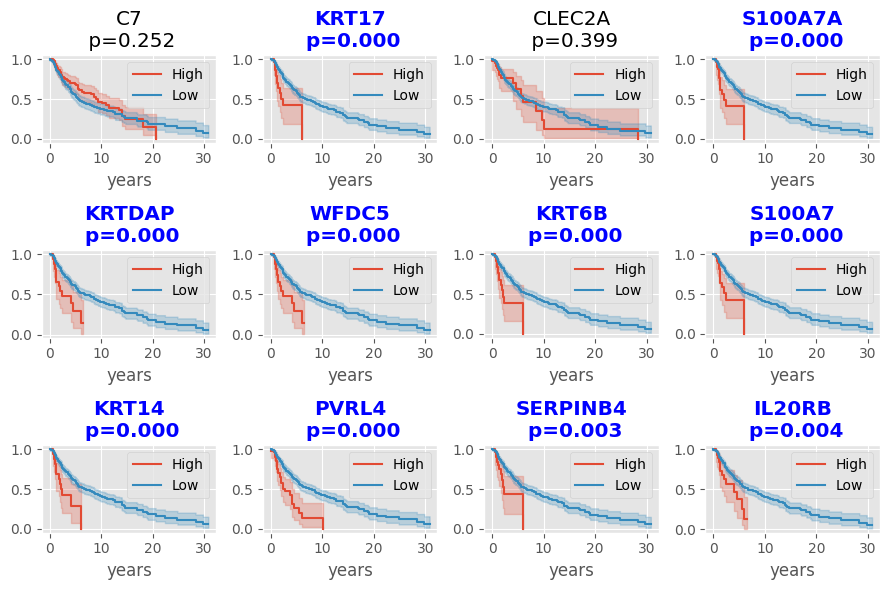

In [246]:
plot_kmf(0)

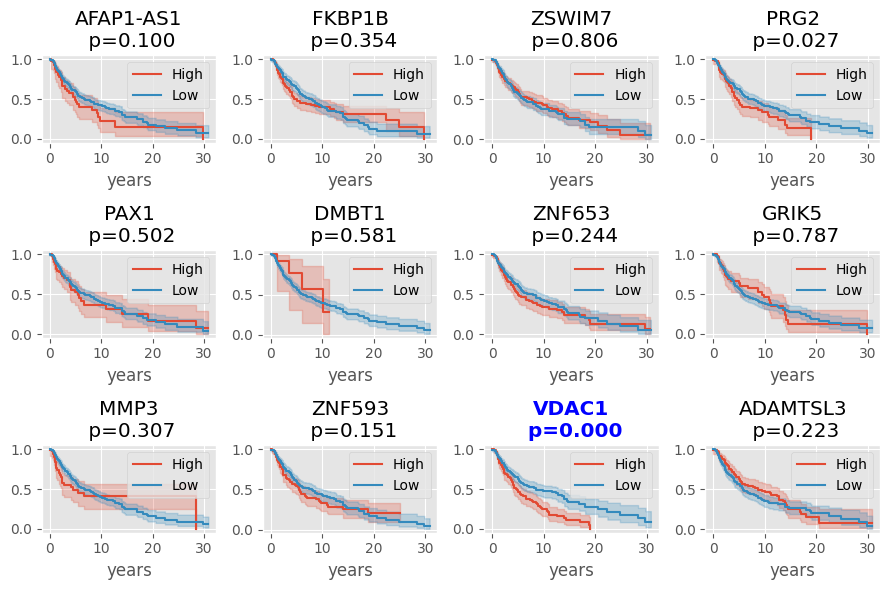

In [247]:
plot_kmf(1)

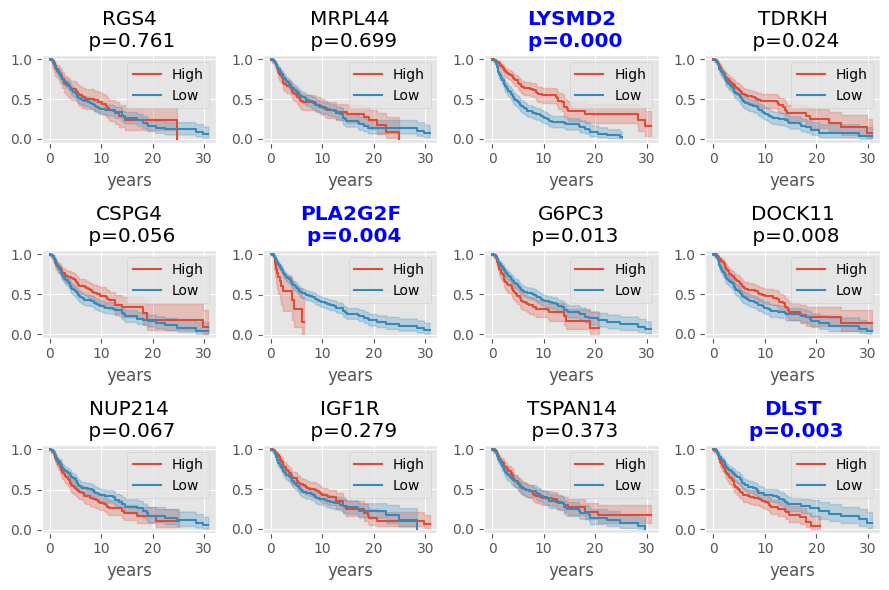

In [248]:
plot_kmf(2)

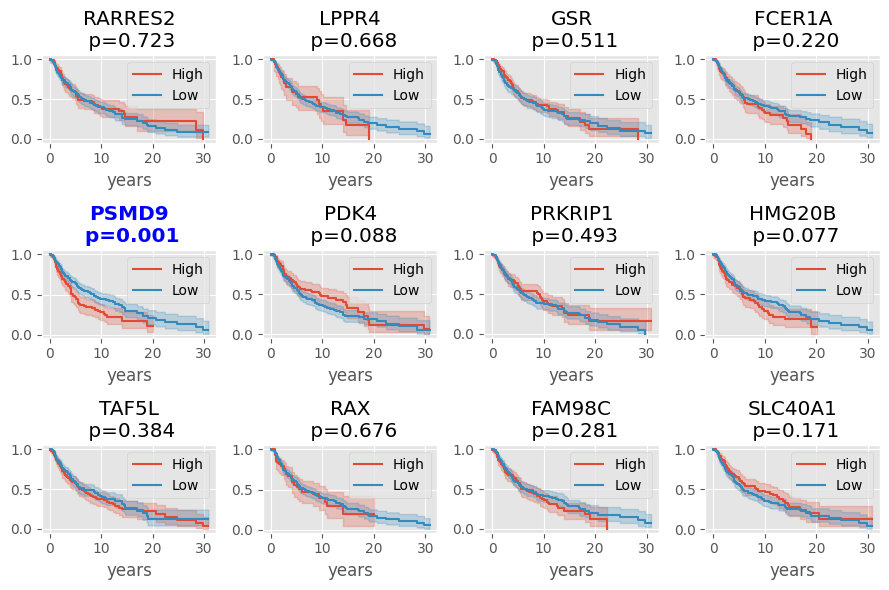

In [249]:
plot_kmf(3)

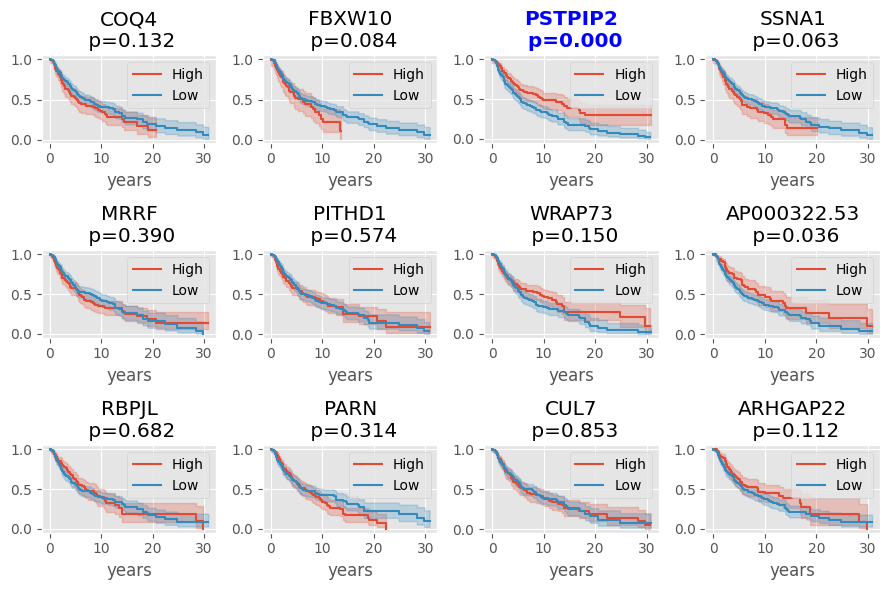

In [250]:
plot_kmf(4)

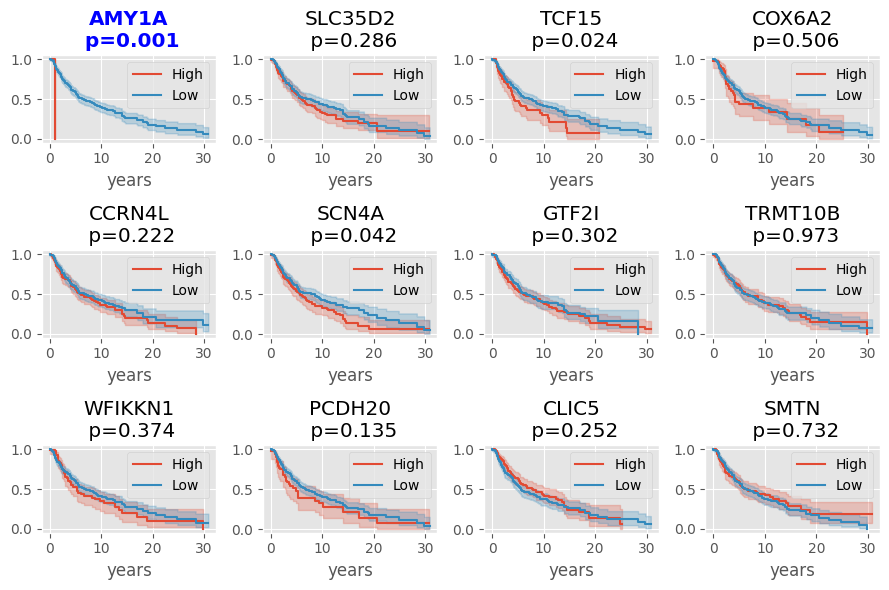

In [251]:
plot_kmf(5)

In [252]:
thresholds_df = pd.DataFrame(index = top_genes, columns = ["normal", "median","mean"])
thresholds_df["normal"] = df_normal[top_genes].values.T
thresholds_df["median"] = df_[top_genes].median().values.T
thresholds_df["mean"]   = df_[top_genes].mean().values.T
thresholds_df

,normal,median,mean
C7,1.270219,-0.352055,-0.005866
KRT17,-0.132078,-0.131983,0.003170
CLEC2A,-0.207658,-0.207658,0.004987
S100A7A,-0.152521,-0.152698,0.003666
KRTDAP,-0.178332,-0.178332,0.004281
WFDC5,-0.186721,-0.186721,0.004477
KRT6B,-0.132731,-0.132716,0.003188
S100A7,-0.181423,-0.181423,0.004357
KRT14,-0.129025,-0.128972,0.003098
PVRL4,-0.261939,-0.248006,0.005765


In [253]:
thresholds_df.to_csv("../data/kaplan_meier_thresholds_rf_ppi.csv")